## Customer Segmentation
###### Group2

### Why?
為了了解來自不同客戶群的價值

### How?
對資料做cohert、RFM分析、Kmeans分群

### Dataset
線上零售商店

### content
1. Data Pre-processing
2. Cohert Analysis
3. RFM
4. K-Means

### 1. Data Pre-processing

#### 1.1 get data

In [1]:
import numpy as np 
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# sns.set_palette('Set2')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Supress Scientific notation in python #小數點後兩位
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display all columns of long dataframe #顯示所有columns
pd.set_option('display.max_columns', None)

import time
import datetime as dt

In [2]:
# Import datasets
path = ''
train = pd.read_excel(path+'Online Retail.xlsx', parse_dates=['InvoiceDate']) #讀取InvoiceDate為日期

In [3]:
# Check the shape of dataset
train.shape

(541909, 8)

In [4]:
#資料減量
test1 = train.sample(frac = .3).reset_index(drop = True)
test2 = train.sample(10000, random_state = 42)
print(test1.shape)
print(test2.shape)

(162573, 8)
(10000, 8)


In [5]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


#### 1.2 Duplicate data

In [6]:
# Remove duplicate items 
print(f'Duplicate items in train dataset is {train.duplicated().sum()}')
train = train[~train.duplicated()]
print(f'Duplicate items in train dataset is {train.duplicated().sum()}')

Duplicate items in train dataset is 5268
Duplicate items in train dataset is 0


#### 1.3 Missing values

In [7]:
train.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [8]:
# 將missing values變成table
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        # Make a table with the results  #總數、百分比放在一起
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns #加columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"+"There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(train)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CustomerID,135037,25.20
Description,1454,0.30


In [10]:
#去除空的customerID
rfm_train = train[train.CustomerID.notnull()].copy()

#CustomerID轉INT
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

missing_values_table(rfm_train)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### 1.4 Cancelled items

In [11]:
# 移除取消的InvoiceNo 
desc_df = rfm_train[~rfm_train.InvoiceNo.str.contains('C', na=False)] # ~含c的 -> 不含c的
print(len(desc_df))

392732


In [12]:
# 新增Total_cost欄位
desc_df['Total_cost'] = rfm_train.Quantity * rfm_train.UnitPrice
desc_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 1.5 EDA (Exploratory Data Analysis)

In [13]:
print(f'data開始日 - {desc_df.InvoiceDate.min()}\n')
print(f'data結束日 - {desc_df.InvoiceDate.max()}')

data開始日 - 2010-12-01 08:26:00

data結束日 - 2011-12-09 12:50:00


從2010/12/1-2011/12/9的跨國資料集

In [14]:
# 列出有最高交易量的國家
# normalize=True 百分比/ mul->multily乘法
desc_df.Country.value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: Country, dtype: object

約 90% 資料來自英國

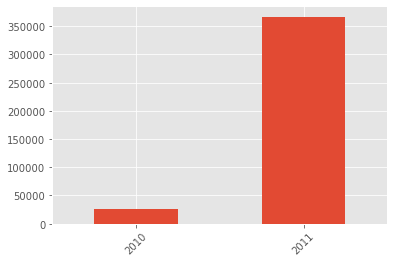

In [15]:
# 不同年份交易量
plt.figure(figsize=(6,4))
desc_df.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', rot=45);

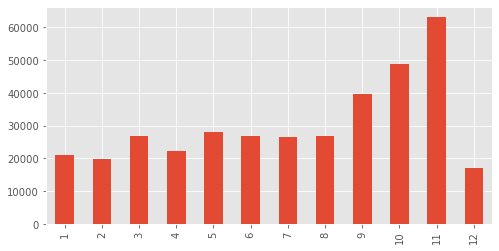

In [16]:
# 2011不同月份交易量
plt.figure(figsize=(8,4))
desc_df[desc_df.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar');

11到12月突然下降，因2011/12只到9號

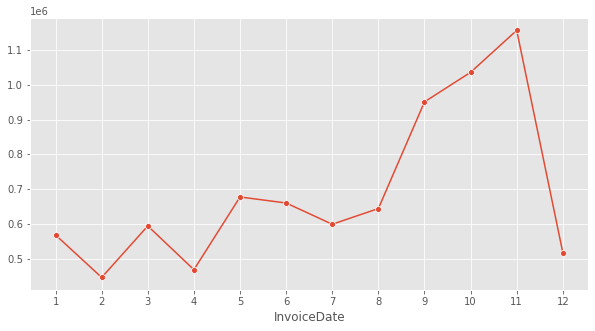

In [17]:
# 畫出2011每個月分的totocost
monthly_gross = desc_df[desc_df.InvoiceDate.dt.year==2011].groupby(desc_df.InvoiceDate.dt.month).Total_cost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o');
plt.xticks(range(1,13))
plt.show();

In [18]:
print(f'data結束日 - {desc_df.InvoiceDate.max()}')

data結束日 - 2011-12-09 12:50:00


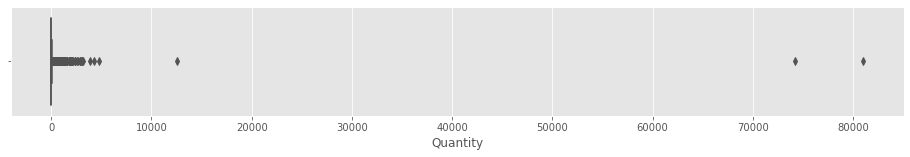

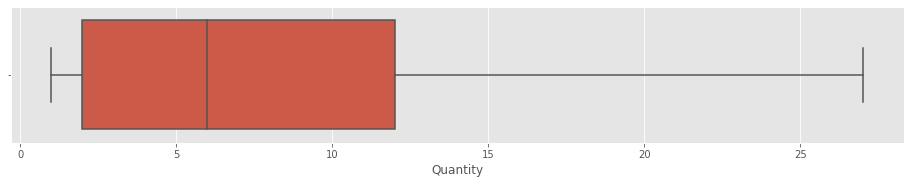

In [19]:
# 資料中購買數量的分佈
plt.figure(figsize=(16,2))
sns.boxplot(x = desc_df['Quantity']);
plt.show()

plt.figure(figsize=(16,2.5))
sns.boxplot(x = desc_df['Quantity'] ,showfliers=False);
plt.show()

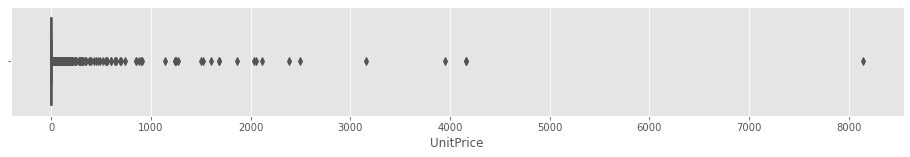

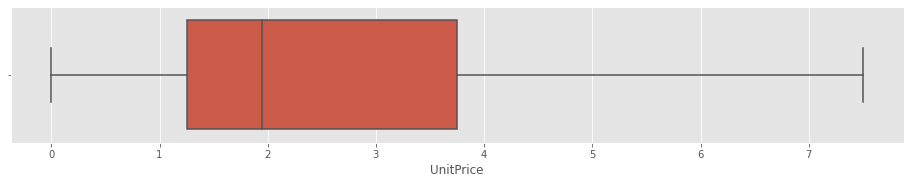

In [20]:
# 單價
plt.figure(figsize=(16,2))
sns.boxplot(x='UnitPrice', data=desc_df);
plt.show()

plt.figure(figsize=(16,2.5))
sns.boxplot(x = desc_df['UnitPrice'] ,showfliers=False);
plt.show()

In [21]:
desc_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


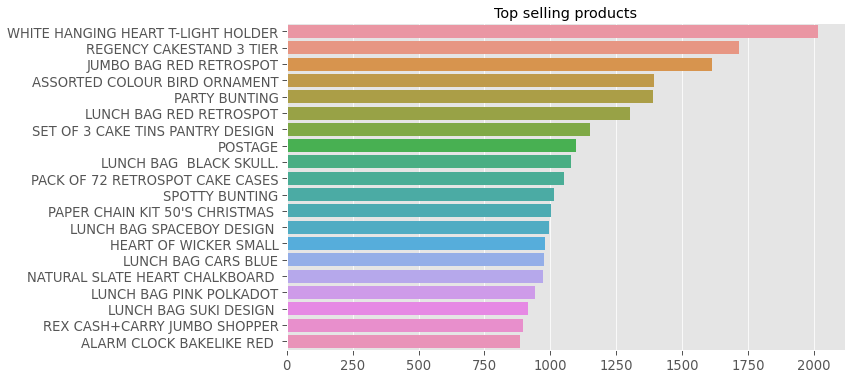

In [22]:
# 取商品數量的20名
# value_counts()會自己sort
top_products = desc_df['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5) #線條的粗細，paper、notebook、talk、poster
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();

In [23]:
desc_df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2016
REGENCY CAKESTAND 3 TIER              1714
JUMBO BAG RED RETROSPOT               1615
ASSORTED COLOUR BIRD ORNAMENT         1395
PARTY BUNTING                         1390
                                      ... 
CRACKED GLAZE EARRINGS RED               1
WHITE/PINK MINI CRYSTALS NECKLACE        1
EASTER CRAFT IVY WREATH WITH CHICK       1
IVORY SHELL HEART EARRINGS               1
MINT DINER CLOCK                         1
Name: Description, Length: 3877, dtype: int64

### 2. Cohert Analysis 同類群組分析

#### 2.1 Cohort Analysis 的類型有以下三種:

##### Time Cohorts
在特定時間範圍內購買產品或受到服務的客戶，例如開始使用公司產品或是開始玩遊戲的時間，時間可以是月份、季度或是每天作為單位。

##### Behavior cohorts
是曾經購買產品或訂閱服務的客戶，會按照客戶購買的產品或服務類型對客戶進行分組，購買基本級別服務的客戶可能與購買高級服務的客戶有不同的需求。了解不同群體的需求可以幫助公司為特定細分市場設計定制服務或產品。

##### Size cohorts
指購買公司產品或服務的各種規模的客戶。這種分類可以基於購買後某個週期內的消費金額或客戶在某個時期內消費了大部分訂單金額的產品類型。

#### 2.2 Time Cohorts

##### 分月份群組
根據每個客戶進行第一次交易的月份創建每月同類群組。

In [24]:
#先複製一份資料
cohort = rfm_train.copy()
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [25]:
# 轉換日期的函數
def get_month(x):
    return dt.datetime(x.year,x.month,1) #不需要用到日所以都設為1

# 新增一個 InvoiceMonth column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month) # 發票日期

# 用 CustomerID 和 InvoiceMonth 分組
grouping = cohort.groupby('CustomerID')['InvoiceMonth'] 

# 找出該顧客第一次消費的日期
cohort['CohortMonth'] = grouping.transform('min') #同一個會員編號 第一次購買的年月份

In [26]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01


##### 計算以月為單位的時間間隔
計算每個消費的時間間隔能夠用可比較的方式報告每個群組的指標。
先用使用 get_date_int() 函數捕獲 Invoice 和 Cohort Date 的年份和月份的整數值

In [27]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month #回傳年和月

In [28]:
# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth') #把年月分開

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')#把年月分開

In [29]:
# Calculate difference in years
years_diff = invoice_year - cohort_year #第一次買的年份跟最後一次買的間隔

# Calculate difference in months
months_diff = invoice_month - cohort_month #第一次買的月份跟最後一次買的間隔

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1 #分組 

In [30]:
cohort

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,2011-12-01,2011-08-01,5
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,2011-12-01,2011-08-01,5
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-01,2011-08-01,5
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-01,2011-08-01,5


##### 計算留存率 Retention 留住的客戶
客戶保留率是一個非常有用的指標，可以了解有多少客戶仍然活躍，提供了活躍客戶佔客戶總數的百分比

In [31]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])#第一次購買時間跟持續購買的間隔

# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

In [32]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.00,362.00,317.00,367.00,341.00,376.00,360.00,336.00,336.00,374.00,354.00,474.00,260.00
2011-01-01,421.00,101.00,119.00,102.00,138.00,126.00,110.00,108.00,131.00,146.00,155.00,63.00,nan
2011-02-01,380.00,94.00,73.00,106.00,102.00,94.00,97.00,107.00,98.00,119.00,35.00,nan,nan
2011-03-01,440.00,84.00,112.00,96.00,102.00,78.00,116.00,105.00,127.00,39.00,nan,nan,nan
2011-04-01,299.00,68.00,66.00,63.00,62.00,71.00,69.00,78.00,25.00,nan,nan,nan,nan
2011-05-01,279.00,66.00,48.00,48.00,60.00,68.00,74.00,29.00,nan,nan,nan,nan,nan
2011-06-01,235.00,49.00,44.00,64.00,58.00,79.00,24.00,nan,nan,nan,nan,nan,nan
2011-07-01,191.00,40.00,39.00,44.00,52.00,22.00,nan,nan,nan,nan,nan,nan,nan
2011-08-01,167.00,42.00,42.00,42.00,23.00,nan,nan,nan,nan,nan,nan,nan,nan


In [33]:
cohort_sizes # 取直的第一排

CohortMonth
2010-12-01   948.00
2011-01-01   421.00
2011-02-01   380.00
2011-03-01   440.00
2011-04-01   299.00
2011-05-01   279.00
2011-06-01   235.00
2011-07-01   191.00
2011-08-01   167.00
2011-09-01   298.00
2011-10-01   352.00
2011-11-01   321.00
2011-12-01    41.00
Name: 1, dtype: float64

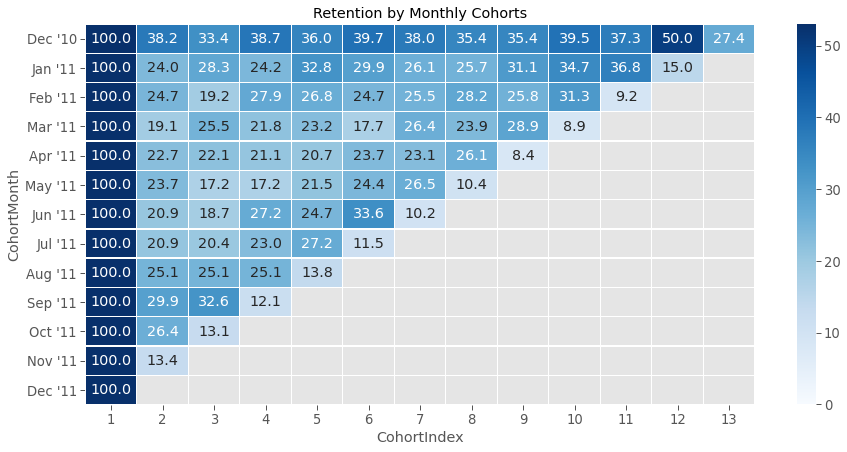

In [34]:
# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)*100 #拿第一排去除全部

month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

# Initialize inches plot figure
plt.figure(figsize=(15,7)) #15*7

# Add a title 上方的標題
plt.title('Retention by Monthly Cohorts')

# Create the heatmap 熱點圖
sns.heatmap(data=retention,
            annot = True, #把每個資料都寫進格子 或是不寫數字
            cmap = "Blues",#顏色
            vmin = 0.0,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,#顏色
            fmt = '.1f',#小數點
            linewidth = 0.3,
            yticklabels=month_list) #y軸

plt.show();

#### 2.3 Behavior cohorts

##### 計算每個群組的平均價格
現在我們將計算平均價格指標並分析不同時間和不同群組的購物模式是否存在任何差異。

In [35]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])  

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean() #以月分為主 看每一組index的平均消費價錢

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index() #給他一個新的index

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')


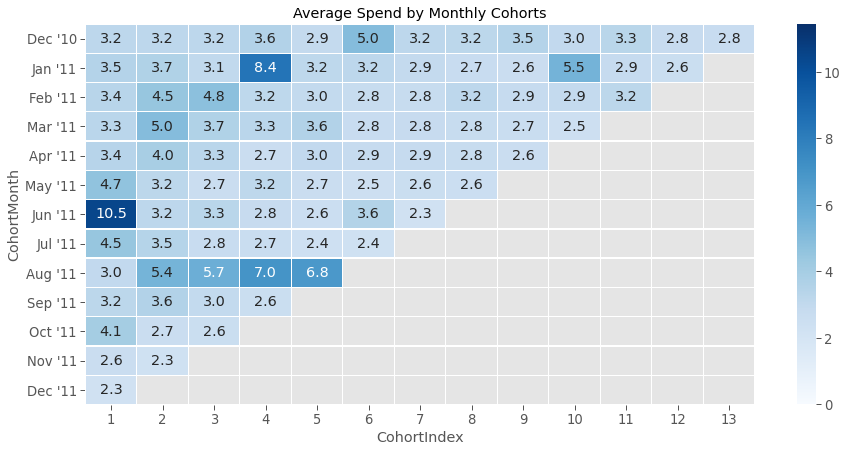

In [36]:
# Initialize plot figure
plt.figure(figsize=(15, 7)) #15*7

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_price,
            annot=True,
            vmin = 0.0,
            cmap='Blues',
            vmax = list(average_price.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

#### 2.4 Size cohorts

##### 計算每個群組的平均價格
現在我們將計算平均價格指標並分析不同時間和不同群組的購物模式是否存在任何差異。

In [37]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = cohort.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the Quantity column
cohort_data = grouping['Quantity'].mean()#購買數量平均值

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')


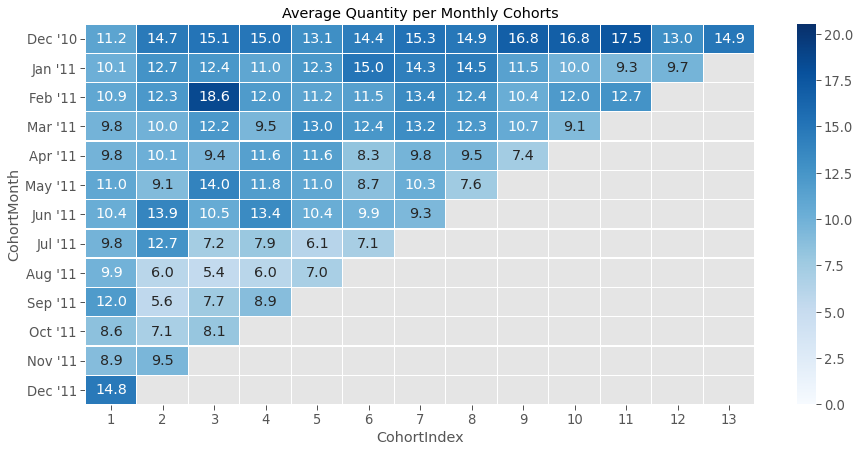

In [38]:
# Initialize plot figure
plt.figure(figsize=(15, 7))#15*7

# Add a title
plt.title('Average Quantity per Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_quantity,
            annot=True,
            vmin = 0.0,
            cmap='Blues',
            vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

### 3. RFM

#### 3.1 Recency  
是關於客戶的最後一個訂單的時間。它表示自客戶上次購買以來的天數

In [39]:
#last date available in our dataset
#data裡面最新的資料
rfm_train['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [40]:
# Lets set this date as the today's date for further analysis
#設為當前日期
current_date = dt.date(2011,12,9)

In [41]:
# Lets create a date column for date values only
#新增'Purchase_Date'欄位
rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date

In [42]:
rfm_train

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Purchase_Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-09


In [43]:
#找出每位顧客的最新的消費日期
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [44]:
recency

,CustomerID,Purchase_Date
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02
...,...,...
4367,18280,2011-03-07
4368,18281,2011-06-12
4369,18282,2011-12-02
4370,18283,2011-12-06


In [45]:
# Create a separate column for this date.
#新增Current_Date欄位，值為current_date
recency = recency.assign(Current_Date = current_date)

In [46]:
# Compute the number of days since last purchase
#計算上次購買以來的天數
recency['Recency'] = recency.Purchase_Date.apply(lambda x: (current_date - x).days)

In [47]:
recency.head()

,CustomerID,Purchase_Date,Current_Date,Recency
0,12346,2011-01-18,2011-12-09,325
1,12347,2011-12-07,2011-12-09,2
2,12348,2011-09-25,2011-12-09,75
3,12349,2011-11-21,2011-12-09,18
4,12350,2011-02-02,2011-12-09,310


In [48]:
# Drop the irrelevant Date columns
#把Purchase_Date、Current_Date刪除留下Recency
recency.drop(['Purchase_Date','Current_Date'], axis=1, inplace=True)

In [49]:
recency

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310
...,...,...
4367,18280,277
4368,18281,180
4369,18282,7
4370,18283,3


#### 3.2 Frequency 
是關於給定時間段內的購買次數。可以將這個值理解為客戶使用公司產品的頻率或數量。價值越大，客戶參與度越高

In [50]:
#找出交易次數
frequency = rfm_train.groupby('CustomerID').InvoiceNo.nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})

In [51]:
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


#### 3.3 Monetary 
是客戶在特定時期內花費的總金額。

In [52]:
# Create a separate column for Total Cost of Unit purchased
rfm_train['Total_cost'] = rfm_train.Quantity * rfm_train.UnitPrice

In [53]:
monetary = rfm_train.groupby('CustomerID').Total_cost.sum().reset_index().rename(columns={'Total_cost':'Monetary'})

In [54]:
monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


#### 3.4 將三者結合起來形成一個聚合的 RFM 表

In [55]:
temp_ = recency.merge(frequency, on='CustomerID')
rfm_table = temp_.merge(monetary, on='CustomerID')

In [56]:
rfm_table.set_index('CustomerID',inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


In [57]:
# Fetch the records corresponding to the first customer id in above table
#第一個顧客id對應的資料
rfm_train[rfm_train.CustomerID == rfm_table.index[0]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Purchase_Date,Total_cost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011-01-18,77183.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,2011-01-18,-77183.60


In [58]:
# Check if the number difference of days from the purchase date in original record is same as shown in rfm table.
#檢查原始記錄中與購買日期的天數差異是否與rfm表中顯示的相同。
(current_date - rfm_train[rfm_train.CustomerID == rfm_table.index[0]].iloc[0].Purchase_Date).days == rfm_table.iloc[0,0]

True

In [59]:
# RFM Quantiles
#分位數
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,16.00,1.00,291.79
0.50,50.00,3.00,644.07
0.75,143.00,5.00,1608.34


In [60]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quantiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [61]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quantiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [62]:
rfm_segment = rfm_table.copy()
rfm_segment['R_Quartile'] = rfm_segment['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segment['F_Quartile'] = rfm_segment['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segment['M_Quartile'] = rfm_segment['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [63]:
rfm_segment.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346,325,2,0.00,1,2,1
12347,2,7,4310.00,4,4,4
12348,75,4,1797.24,2,3,4
12349,18,1,1757.55,3,1,4
12350,310,1,334.40,1,1,2


In [64]:
rfm_segment['RFMScore'] = rfm_segment.R_Quartile.map(str) \
                            + rfm_segment.F_Quartile.map(str) \
                            + rfm_segment.M_Quartile.map(str)
rfm_segment.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,2,0.00,1,2,1,121
12347,2,7,4310.00,4,4,4,444
12348,75,4,1797.24,2,3,4,234
12349,18,1,1757.55,3,1,4,314
12350,310,1,334.40,1,1,2,112


In [65]:
rfm_segment['RFMScore'].nunique()

63

In [66]:
# Reset the index to create a customer_ID column
rfm_segment.reset_index(inplace=True)

In [67]:
# Create a dictionary for each segment to map them against each customer
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency 
    'Loyal Customers':'344',      # High frequency as well as monetary value with good recency
    'Big Spenders':'334',       # High monetary value but good recency and frequency values
    'Almost Lost':'244',        # Customer's shopping less often now who used to shop a lot
    'Lost Customers':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',     # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122'   # Customer's shopped long ago but with less frequency and monetary value
}

In [68]:
# Swap the key and value of dictionary
#交換key跟value
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

In [69]:
# Allocate segments to each customer as per the RFM score mapping
rfm_segment['Segment'] = rfm_segment.RFMScore.map(lambda x: dict_segment.get(x))

In [70]:
# Allocate all remaining customers to others segment category
#其他值填入others
rfm_segment.Segment.fillna('others', inplace=True)

In [71]:
rfm_segment.sample(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
4066,17871,204,1,155.90,1,1,1,111,others
2743,16057,4,10,2140.22,4,4,4,444,Best Customers
4342,18245,7,8,2507.56,4,4,4,444,Best Customers
1719,14666,24,1,195.25,3,1,1,311,others
1906,14930,108,3,2362.96,2,2,4,224,others
2195,15314,199,1,327.97,1,1,2,112,others
2313,15472,113,1,371.56,2,1,2,212,others
3652,17311,78,2,1384.85,2,2,3,223,others
3031,16444,46,5,638.77,3,3,2,332,others
2250,15389,172,1,500.00,1,1,2,112,others


In [72]:
# Best Customers who's recency, frequency as well as monetary attribute is highest.
rfm_segment[rfm_segment.RFMScore=='444'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
1703,14646,1,77,279489.02,4,4,4,444,Best Customers
4233,18102,0,62,256438.49,4,4,4,444,Best Customers
3758,17450,8,55,187322.17,4,4,4,444,Best Customers
1895,14911,1,248,132458.73,4,4,4,444,Best Customers
1345,14156,9,66,113214.59,4,4,4,444,Best Customers


In [73]:
# Biggest spenders
rfm_segment[rfm_segment.RFMScore=='334'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
2794,16126,29,4,6287.77,3,3,4,334,Big Spenders
737,13316,37,5,5570.69,3,3,4,334,Big Spenders
2923,16303,25,4,5305.83,3,3,4,334,Big Spenders
2897,16258,45,5,5203.51,3,3,4,334,Big Spenders
70,12432,42,5,5059.32,3,3,4,334,Big Spenders


In [74]:
# Almost Lost i.e. who's recency value is low
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
464,12939,64,8,11581.80,2,4,4,244,Almost Lost
50,12409,78,7,11056.93,2,4,4,244,Almost Lost
2836,16180,100,10,10217.48,2,4,4,244,Almost Lost
328,12744,51,10,9120.39,2,4,4,244,Almost Lost
3248,16745,86,18,7157.10,2,4,4,244,Almost Lost


In [75]:
# Lost customers that don't needs attention who's recency, frequency as well as monetary values are low
rfm_segment[rfm_segment.RFMScore=='122'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
1578,14481,164,2,636.51,1,2,2,122,Lost Cheap Customers
2246,15384,169,3,635.76,1,2,2,122,Lost Cheap Customers
1230,14000,206,2,633.71,1,2,2,122,Lost Cheap Customers
1985,15045,151,3,633.66,1,2,2,122,Lost Cheap Customers
1391,14220,247,2,632.40,1,2,2,122,Lost Cheap Customers


In [76]:
# loyal customers who's purchase frequency is high
rfm_segment[rfm_segment.RFMScore=='344'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
55,12415,24,26,123725.45,3,4,4,344,Loyal Customers
2722,16029,38,76,53168.69,3,4,4,344,Loyal Customers
3014,16422,17,75,33805.69,3,4,4,344,Loyal Customers
458,12931,21,20,33462.81,3,4,4,344,Loyal Customers
1728,14680,25,23,26932.34,3,4,4,344,Loyal Customers


In [77]:
# customers that you must retain are those whose monetary and frequency was high but recency reduced quite a lot recently
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
464,12939,64,8,11581.80,2,4,4,244,Almost Lost
50,12409,78,7,11056.93,2,4,4,244,Almost Lost
2836,16180,100,10,10217.48,2,4,4,244,Almost Lost
328,12744,51,10,9120.39,2,4,4,244,Almost Lost
3248,16745,86,18,7157.10,2,4,4,244,Almost Lost


### 4. K-Means Clustering

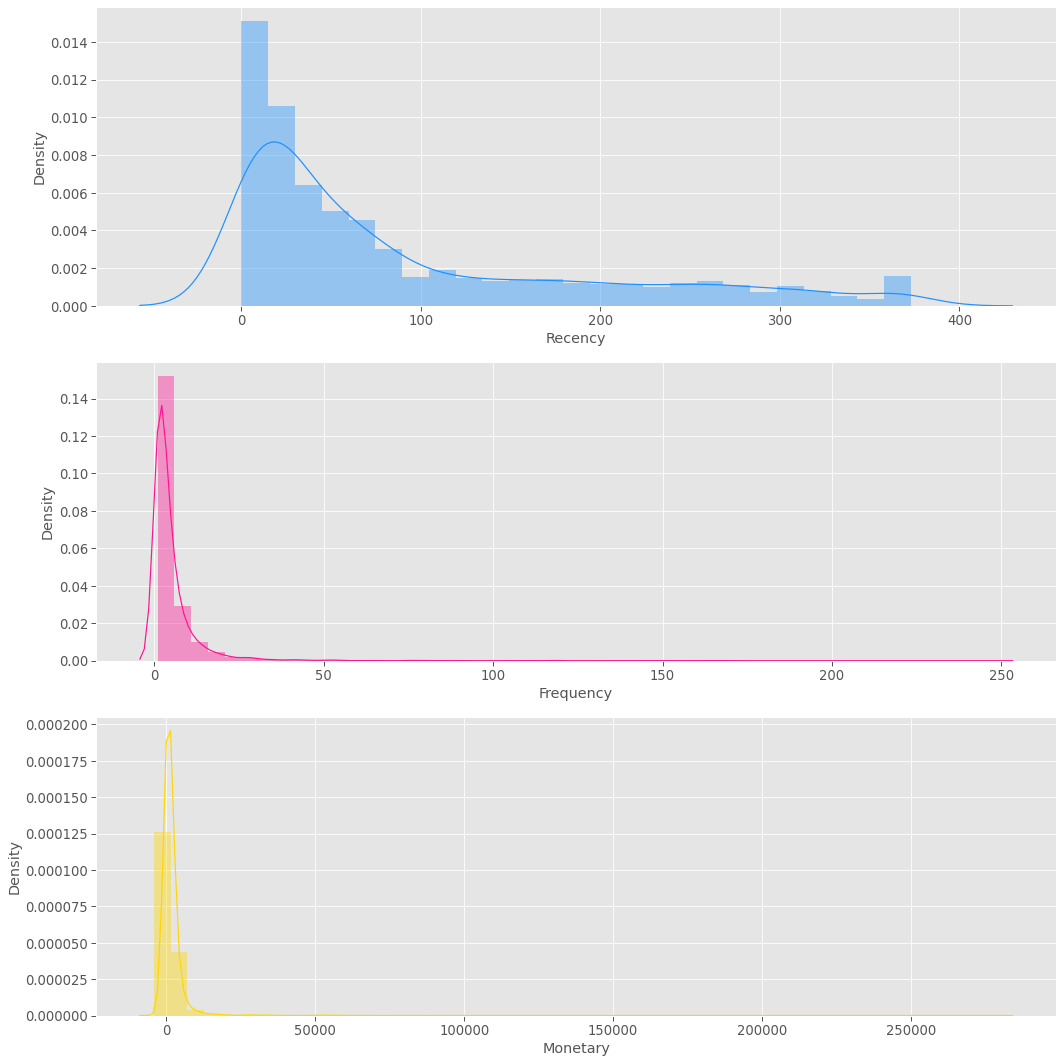

In [78]:
# plot
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(rfm_table.Recency, color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(rfm_table.Frequency, color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(rfm_table.Monetary, color="gold", ax=axes[2], axlabel='Monetary')
plt.tight_layout()
plt.show()

In [79]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4372.00,4372.00,4372.00
mean,91.58,5.08,1893.53
std,100.77,9.34,8218.70
min,0.00,1.00,-4287.63
25%,16.00,1.00,291.79
50%,50.00,3.00,644.07
75%,143.00,5.00,1608.34
max,373.00,248.00,279489.02


In [80]:
# Create a copy of rfm table
rfm_table_scaled = rfm_table.copy()

# Shift all values in the column by adding absolute of minimum value to each value, thereby making each value positive.
rfm_table_scaled.Monetary = rfm_table_scaled.Monetary + abs(rfm_table_scaled.Monetary.min()) + 1
rfm_table_scaled.Recency = rfm_table_scaled.Recency + abs(rfm_table_scaled.Recency.min()) + 1

# Check the summary of new values
rfm_table_scaled.describe()

,Recency,Frequency,Monetary
count,4372.00,4372.00,4372.00
mean,92.58,5.08,6182.16
std,100.77,9.34,8218.70
min,1.00,1.00,1.00
25%,17.00,1.00,4580.43
50%,51.00,3.00,4932.70
75%,144.00,5.00,5896.97
max,374.00,248.00,283777.65


In [81]:
# Transform the data before K-Means clustering
from sklearn.preprocessing import StandardScaler

# Taking log first because normalization forces data for negative values
log_df = np.log(rfm_table_scaled)

# Normalize the data for uniform averages and means in the distribution.
scaler = StandardScaler()
normal_df = scaler.fit_transform(log_df)
normal_df = pd.DataFrame(data=normal_df, index=rfm_table.index, columns=rfm_table.columns)

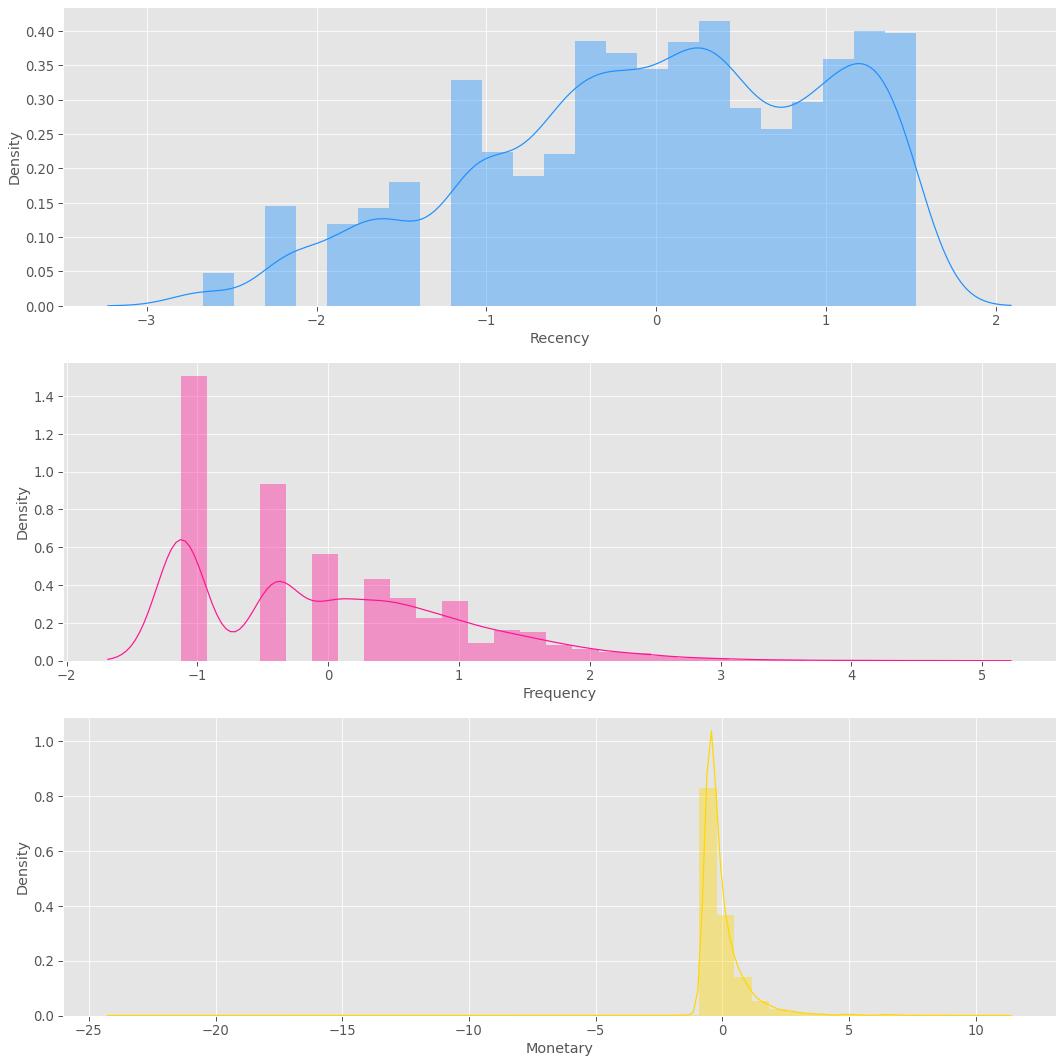

In [82]:
# plot again on the transformed RFM data
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_df.Recency, color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(normal_df.Frequency, color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_df.Monetary, color="gold", ax=axes[2], axlabel='Monetary')
plt.tight_layout()
plt.show()

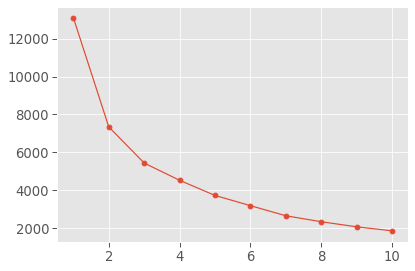

In [83]:
# find WCSS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(normal_df)
    wcss.append(kmeans.inertia_)

# plot elbow graph
plt.plot(range(1, 11), wcss, marker='o')
plt.tight_layout()
plt.show()

Silhouette score for number of cluster(s) 2: 0.4405297656150766
Silhouette score for number of cluster(s) 3: 0.3967504690109654
Silhouette score for number of cluster(s) 4: 0.35046863106007997
Silhouette score for number of cluster(s) 5: 0.36166861264035577
Silhouette score for number of cluster(s) 6: 0.36486216225288387
Silhouette score for number of cluster(s) 7: 0.35445191505198254
Silhouette score for number of cluster(s) 8: 0.33932511699064893
Silhouette score for number of cluster(s) 9: 0.3436531967884225
Silhouette score for number of cluster(s) 10: 0.35333869474160057
Silhouette score for number of cluster(s) 11: 0.3607881642107286


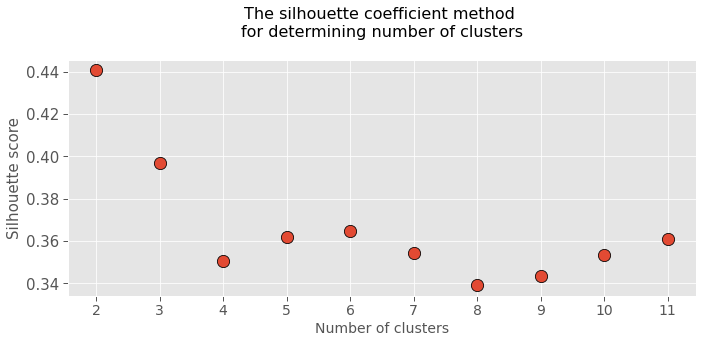

In [84]:
from sklearn.metrics import silhouette_score
wcss_silhouette = []
for i in range(2, 12):
    km = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(normal_df)
    preds = km.predict(normal_df)    
    silhouette = silhouette_score(normal_df, preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i, silhouette))

plt.figure(figsize=(10, 5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n", fontsize=16)
plt.scatter(x=[ i for i in range(2,12) ], y=wcss_silhouette, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette score", fontsize=15)
plt.xticks([ i for i in range(2, 12) ], fontsize=14)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [85]:
kmeans = KMeans(n_clusters=4, random_state=1, init='k-means++')
kmeans.fit(normal_df)
cluster_labels = kmeans.labels_

In [86]:
kmeans

KMeans(n_clusters=4, random_state=1)

In [87]:
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")

Shape of cluster label array is (4372,)
Shape of RFM segment dataframe is (4372, 9)


In [88]:
# Assign the clusters as column to each customer
Cluster_table = rfm_segment.assign(Cluster=cluster_labels)

In [89]:
# Check counts of records assigned to different clusters
Cluster_table.Cluster.value_counts()

2    1781
0    1595
1     875
3     121
Name: Cluster, dtype: int64

In [90]:
Cluster_table.sample(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
1577,14480,11,1,279.05,4,1,1,411,others,0
481,12963,8,9,1841.03,4,4,4,444,Best Customers,1
4005,17783,72,2,283.47,2,2,1,221,others,2
2610,15864,22,8,1769.78,3,4,4,344,Loyal Customers,1
1370,14194,4,32,11216.75,4,4,4,444,Best Customers,3
3670,17339,94,2,243.36,2,2,1,221,others,2
2542,15777,241,5,1021.61,1,3,3,133,others,2
3080,16510,372,1,248.10,1,1,1,111,others,2
2959,16351,332,1,153.90,1,1,1,111,others,2
3971,17733,38,2,692.19,3,2,3,323,others,0


In [91]:
Cluster_table[Cluster_table.Cluster==3].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
2698,16000,2,3,12393.70,4,2,4,424,others,3
1370,14194,4,32,11216.75,4,4,4,444,Best Customers,3
1615,14527,2,86,7709.69,4,4,4,444,Best Customers,3
698,13263,1,35,7436.93,4,4,4,444,Best Customers,3
652,13199,3,39,9803.96,4,4,4,444,Best Customers,3


In [92]:
Cluster_table[Cluster_table.Cluster==2].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
3798,17508,280,1,387.31,1,1,2,112,others,2
3276,16776,60,1,371.54,2,1,2,212,others,2
1464,14326,234,2,166.85,1,2,1,121,others,2
2632,15899,368,1,56.25,1,1,1,111,others,2
123,12501,315,2,2089.68,1,2,4,124,others,2


In [93]:
Cluster_table[Cluster_table.Cluster==1].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
3935,17690,30,16,4717.30,3,4,4,344,Loyal Customers,1
1682,14621,1,6,1765.76,4,4,4,444,Best Customers,1
1645,14562,3,22,4676.62,4,4,4,444,Best Customers,1
3135,16592,4,19,4073.28,4,4,4,444,Best Customers,1
119,12494,9,13,1139.35,4,4,3,443,Recent Customers,1


In [94]:
Cluster_table[Cluster_table.Cluster==0].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
500,12991,23,2,503.76,3,2,2,322,others,0
3179,16653,16,3,1166.92,4,2,3,423,others,0
3499,17082,33,2,2003.85,3,2,4,324,others,0
1025,13720,116,4,799.90,2,3,3,233,others,0
3082,16513,4,4,874.59,4,3,3,433,others,0


#### Scatter plots

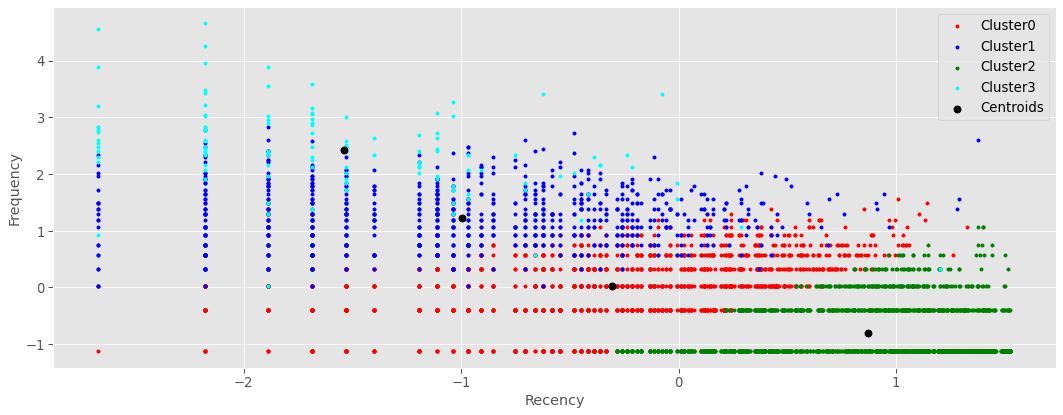

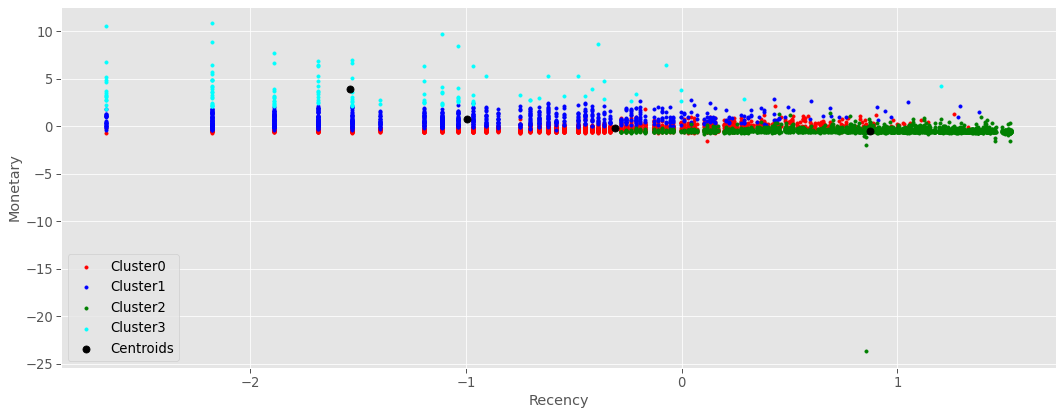

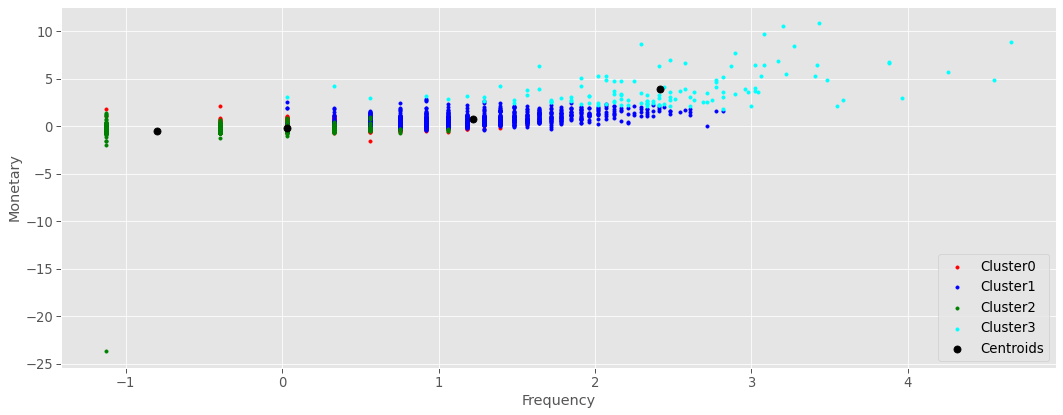

In [95]:
# Plotting two dimesional plots of each attributes respectively.
X = normal_df.iloc[:, 0:3].values
count = X.shape[1]
for i in range(0, count):
    for j in range(i+1, count):
        plt.figure(figsize=(15, 6));
        plt.scatter(X[cluster_labels==0, i], X[cluster_labels==0, j], s=10, c='red', label='Cluster0')
        plt.scatter(X[cluster_labels==1, i], X[cluster_labels==1, j], s=10, c='blue', label='Cluster1')
        plt.scatter(X[cluster_labels==2, i], X[cluster_labels==2, j], s=10, c='green', label='Cluster2')
        plt.scatter(X[cluster_labels==3, i], X[cluster_labels==3, j], s=10, c='cyan', label='Cluster3')
        plt.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], s=50, c='black', label='Centroids')
        plt.xlabel(normal_df.columns[i])
        plt.ylabel(normal_df.columns[j])
        plt.legend()
        plt.tight_layout()
        plt.show()

#### Snake plots 

- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Plot each cluster's average normalized values of each attribute

In [96]:
# Assign Cluster values to each customer in normalized dataframe
normal_df = normal_df.assign(Cluster=cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_df.reset_index(), id_vars=['CustomerID', 'Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric', value_name='Value')
normal_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346,2,Recency,1.43
1,12347,1,Recency,-1.89
2,12348,0,Recency,0.40
3,12349,0,Recency,-0.58
4,12350,2,Recency,1.40


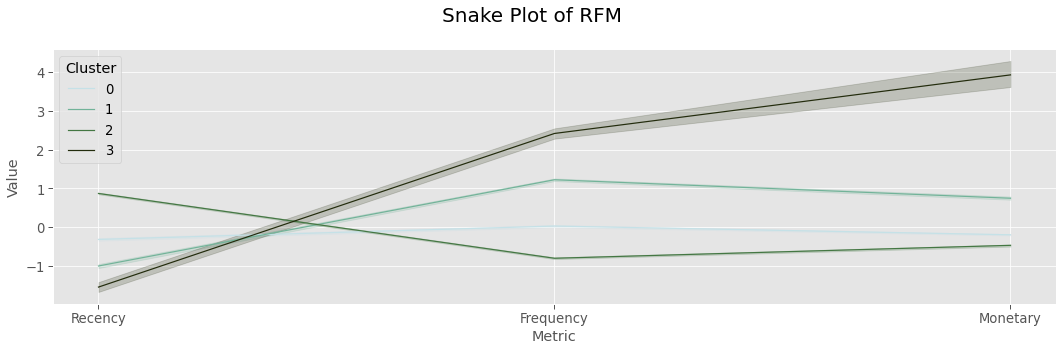

In [97]:
# a snake plot with K-Means
plt.figure(figsize=(15, 5))
palette = sns.color_palette("mako_r", 4)
sns.lineplot(x='Metric', y='Value', hue='Cluster',
             data=normal_melt, palette="ch:4.4,.44")

plt.suptitle("Snake Plot of RFM", fontsize=20)
plt.tight_layout()
plt.show()

#### Heat Map

In [98]:
# Assign Cluster labels to RFM table
rfm_table_cluster = rfm_table.assign(Cluster=cluster_labels)

# Average attributes for each cluster
cluster_avg = rfm_table_cluster.groupby(['Cluster']).mean() 

# Calculate the population average
population_avg = rfm_table.mean()

# Calculate relative importance of attributes by 
relative_imp = cluster_avg / population_avg - 1

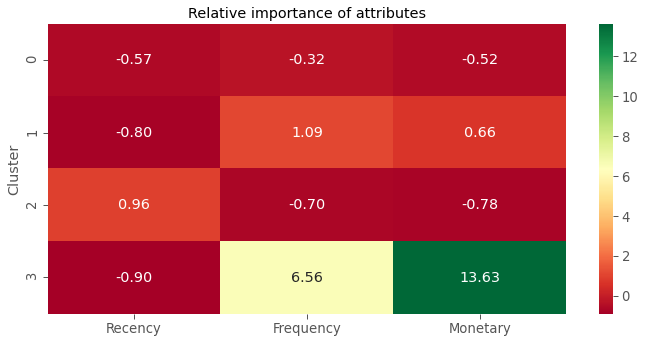

In [99]:
plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.tight_layout()
plt.show()